In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.profiler import Profiler, AdvancedProfiler
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl

In [2]:
path='.'

In [5]:
datapath = 'C:/Users/aleks/Projects/arameic-mishmash/Bachelor/Fit tasks/alpha/Data'
scaled_Qdata = pd.read_csv(f'{datapath}/scaled_QdataKn3width100microns.csv', header=0, index_col=0)  #qdata with Knudsen
dropKn = False
if (dropKn):
    for col in scaled_Qdata.columns:
        if (col[:2]=='Kn'):
            scaled_Qdata = scaled_Qdata.drop(col)
print(scaled_Qdata.shape)
scaled_Qdata.head()

(39799, 18)


,Z_0,Z_1,Z_2,T_0,T_1,T_2,gradT_0,gradT_1,gradT_2,Kn_0,Kn_1,Kn_2,n_0,n_1,n_2,Qimpact_c-1,Qimpact_c,Qimpact_c+1
-0.99495,-0.286203,-0.286203,-0.286203,-0.510985,-0.510985,-0.510985,1.088684e-15,1.088684e-15,1.088684e-15,-0.116664,-0.116664,-0.116664,-0.455651,-0.455731,-0.455811,-0.231718,-0.231718,-0.231718
-0.99490,-0.286203,-0.286203,-0.286203,-0.510985,-0.510985,-0.510985,1.088684e-15,1.088684e-15,1.088684e-15,-0.116664,-0.116664,-0.116664,-0.455652,-0.455732,-0.455812,-0.231718,-0.231718,-0.231718
-0.99485,-0.286203,-0.286203,-0.286203,-0.510985,-0.510985,-0.510985,1.088684e-15,1.088684e-15,1.088684e-15,-0.116664,-0.116664,-0.116664,-0.455653,-0.455733,-0.455813,-0.231718,-0.231718,-0.231718
-0.99480,-0.286203,-0.286203,-0.286203,-0.510985,-0.510985,-0.510985,1.088684e-15,1.088684e-15,1.088684e-15,-0.116664,-0.116664,-0.116664,-0.455654,-0.455734,-0.455814,-0.231718,-0.231718,-0.231718
-0.99475,-0.286203,-0.286203,-0.286203,-0.510985,-0.510985,-0.510985,1.088684e-15,1.088684e-15,1.088684e-15,-0.116664,-0.116664,-0.116664,-0.455655,-0.455735,-0.455815,-0.231718,-0.231718,-0.231718


In [6]:
# convert my predicted values back to actual numbers
data_scaling=pd.read_csv(f'{path}/data_scaling.csv', header=0, index_col=0)
Kn_mean = data_scaling['Kn'].loc['mean']; Kn_std = data_scaling['Kn'].loc['std']
Q_mean = data_scaling['Qimpact'].loc['mean']; Q_std = data_scaling['Qimpact'].loc['std']

In [7]:
validationsize = int(0.2*scaled_Qdata.shape[0]) # 20% of samples for validation
testsize = int(0.2*scaled_Qdata.shape[0]) # 20% of samples for test

In [8]:
shuffled_Qdata=scaled_Qdata.sample(n=scaled_Qdata.shape[0])

validation_data=shuffled_Qdata.iloc[:validationsize]
test_data=scaled_Qdata # All data (not randomized) is kept for visualization of model
train_data=shuffled_Qdata.iloc[validationsize+testsize:]

print('Training dataset size: ', train_data.shape, '\nTesting dataset size: ',test_data.shape,'\nValidation dataset size: ', validation_data.shape)

Training dataset size:  (23881, 18) 
Testing dataset size:  (39799, 18) 
Validation dataset size:  (7959, 18)


In [9]:
threePoint = False
if (threePoint):
    target_fields = ['Qimpact_c-1','Qimpact_c','Qimpact_c+1']
else:
    target_fields = ['Qimpact_c']
drop_fields = ['Qimpact_c-1','Qimpact_c','Qimpact_c+1']

train_features, train_targets = train_data.drop(drop_fields, axis=1), train_data[target_fields]
test_features, test_targets = test_data.drop(drop_fields, axis=1), test_data[target_fields]
validation_features, validation_targets = validation_data.drop(drop_fields, axis=1), validation_data[target_fields]

In [10]:
l_rate = 0.05
mse_loss = nn.MSELoss(reduction = 'mean')

In [11]:
Nfeatures = train_features.shape[1]
Nfields = 5 # 4 # if Kn dropped
Npoints = int(Nfeatures / Nfields)
print(f'Number of points per field {Npoints}')

Number of points per field 3


In [12]:
class Regression(pl.LightningModule):
    
### The Model ### 

    # Question: what will your model architecture look like?
    # Initialize the layers
    # Here we have one input layer (size 56 #3N as we have 56 #3N features), one hidden layer (size 10), 
    # and one output layer (size 1 as we are predicting a single value)
    def __init__(self):
        super(Regression, self).__init__()
        N1 = 20
        N2 = 10
        self.fc1 = nn.Linear(Nfeatures, N1)
        self.fc2 = nn.Linear(N1, N2)
        if (threePoint):
            self.fc3 = nn.Linear(N2, 3)
        else:
            self.fc3 = nn.Linear(N2, 1)            

    def _forward(self, x):
        # Extract features
        featureName = ['Z', 'T', 'gradT', 'Kn', 'n']
        feature = {}
        i = 0
        for name in featureName:
            feature[name] = x[:, i * Npoints:(i+1) * Npoints]
            mean, std = data_scaling[name][0], data_scaling[name][1]
            feature[name] = x[:, i * Npoints:(i+1) * Npoints] * std + mean
            i = i+1
            #print(f'feature name {name}, shape {feature[name].shape}')
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        # Set output to the local heat flux if no large Kn in the kernel interval
        Kn = feature['Kn']
        ip = int(Npoints / 2)
        for i in range(x.shape[0]):
            KnAvg = sum(Kn[i, :]) / Npoints
            #print(f'i {i}, KnAvg {KnAvg}')
            #if (True): #testing local heat flux otherwise use when Kn over the kernel very small (abs(KnAvg) < 1e-3):
            if (KnAvg < 1e-5):
                Z = feature['Z'][i, ip]; T = feature['T'][i, ip]; gradT = feature['gradT'][i, ip]
                kQSH = 6.1e+02 # scaling constant corresponding to the SHICK local heat flux
                Qloc = - kQSH / Z * ((Z + 0.24)/(Z + 4.2)) * T**2.5 * gradT
                x[i] = (Qloc - Q_mean) / Q_std
        return x

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x    
    
### Data loader ### 
    def train_dataloader(self):
        train_dataset = TensorDataset(torch.tensor(train_features.values).float(), torch.tensor(train_targets[target_fields].values).float())
        train_loader = DataLoader(dataset = train_dataset, batch_size = 128)
        return train_loader
        
    def val_dataloader(self):
        validation_dataset = TensorDataset(torch.tensor(validation_features.values).float(),\
                                           torch.tensor(validation_targets[target_fields].values).float())
        validation_loader = DataLoader(dataset = validation_dataset, batch_size = 128)
        return validation_loader
    
    def test_dataloader(self):
        test_dataset = TensorDataset(torch.tensor(test_features.values).float(), torch.tensor(test_targets[target_fields].values).float())
        test_loader = DataLoader(dataset = test_dataset, batch_size = 128)
        return test_loader

### The Optimizer ### 
    def configure_optimizers(self):
        return optim.SGD(self.parameters(), lr=l_rate)

### Training ### 
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = mse_loss(logits, y)
        # Add logging
        logs = {'loss': loss}
        return {'loss': loss, 'log': logs}

### Validation ### 
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = mse_loss(logits, y)
        return {'val_loss': loss}

    # Define validation epoch end
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

### Testing ###     
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = mse_loss(logits, y)
        correct = torch.sum(logits == y.data)
        
        predictions_pred.append(logits)
        predictions_actual.append(y.data)
        return {'test_loss': loss, 'test_correct': correct, 'logits': logits}
    
    # Define test end
    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        logs = {'test_loss': avg_loss}      
        return {'avg_test_loss': avg_loss, 'log': logs, 'progress_bar': logs }

In [13]:
model = Regression()
trainer = Trainer(max_epochs = 100)  # Option to check if it's working at all: fast_dev_run=True 
                                    # Option to implement early stopping: early_stop_callback=True
trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type   | Params
--------------------------------
0 | fc1  | Linear | 320   
1 | fc2  | Linear | 210   
2 | fc3  | Linear | 11    
--------------------------------
541       Trainable params
0         Non-trainable params
541       Total params
0.002     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\aleks\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\aleks\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [14]:
predictions_pred = []
predictions_actual = []
trainer.test()
predictions_pred

C:\Users\aleks\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:134: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at C:\Users\aleks\Projects\arameic-mishmash\Bachelor\Fit tasks\lightning_logs\version_46\checkpoints\epoch=99-step=18700.ckpt
Loaded model weights from checkpoint at C:\Users\aleks\Projects\arameic-mishmash\Bachelor\Fit tasks\lightning_logs\version_46\checkpoints\epoch=99-step=18700.ckpt
C:\Users\aleks\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_w

Testing: 0it [00:00, ?it/s]

[tensor([[-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],
         [-0.2327],


In [15]:
torch.save(model.state_dict(), f'{path}/model.pt')
model.eval()

Regression(
  (fc1): Linear(in_features=15, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)

In [16]:
print('length of pred_actual',len(predictions_actual),'\nsize of tenzors inside pred_actual',predictions_actual[3].size())

length of pred_actual 311 
size of tenzors inside pred_actual torch.Size([128, 1])


In [17]:
# convert my predicted values back to actual numbers
data_scaling=pd.read_csv(f'{path}/data_scaling.csv', header=0, index_col=0)
mean = data_scaling['Qimpact'][0]
std = data_scaling['Qimpact'][1]

# Get predicted points (scaled back to their original size)
if (threePoint):
    Qcomponent = 1
else:
    Qcomponent = 0
plot_pred = []
for i in range(len(predictions_pred)):
    plot_pred.extend(predictions_pred[i].T.numpy()[Qcomponent] * std + mean)
# Save the results to the text file
np.savetxt('Qimpact-NN.txt', np.transpose([scaled_Qdata.index, plot_pred]))

# Get actual points (scaled back to their original size)
plot_actual = []
for i in range(len(predictions_actual)):
    plot_actual.extend(predictions_actual[i].T.numpy()[Qcomponent] * std + mean) 

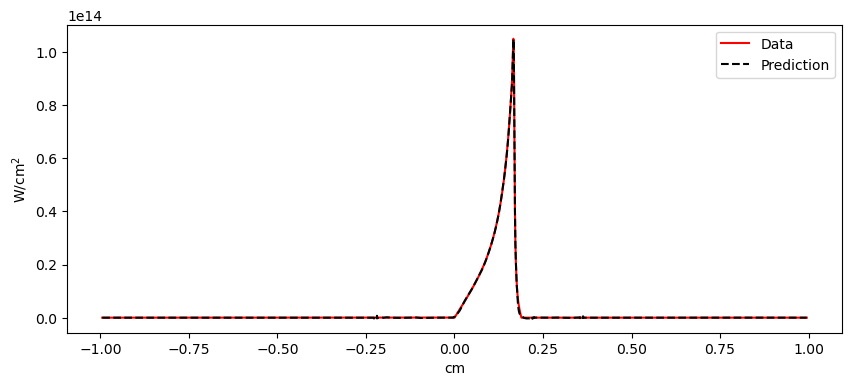

In [18]:
# And finally we can see that our network has done a decent job of estimating!
fig1, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(scaled_Qdata.index,plot_actual, 'r', label='Data')
ax1.plot(scaled_Qdata.index,plot_pred, 'k--', label='Prediction')
ax1.set_xlabel('cm')
ax1.set_ylabel('W/cm$^2$')
ax1.legend()

In [19]:
gradQpred=np.gradient(plot_pred, scaled_Qdata.index)
gradQact=np.gradient(plot_actual, scaled_Qdata.index)

Text(0, 0.5, 'W/cm$^3$')

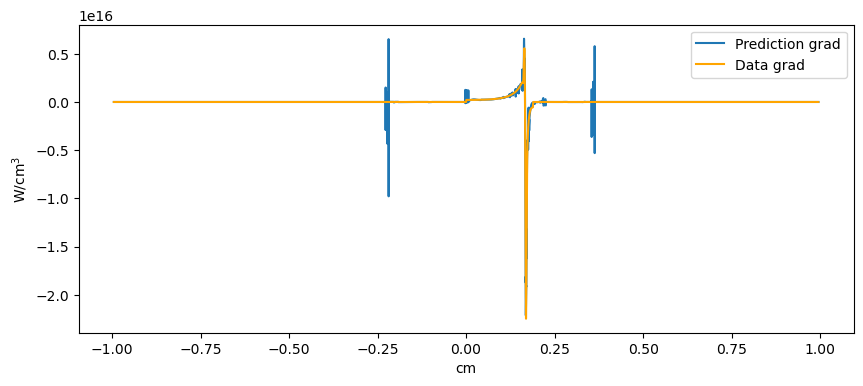

In [20]:
fig2, ax2 = plt.subplots(figsize=(10,4))
ax2.plot(scaled_Qdata.index,gradQpred, label='Prediction grad')
ax2.plot(scaled_Qdata.index,gradQact, label='Data grad', color='orange')
ax2.legend()
ax2.set_xlabel('cm')
ax2.set_ylabel('W/cm$^3$')